In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
path = r"Nox/data/imbalance_actual.csv"
df = pd.read_csv(path)

Set correct index and convert to datetime

In [3]:
df = df.set_index('datetime_utc')
df.index = pd.to_datetime(df.index)

In [4]:
df.describe()

,hour,minute,price_eur_mwh
count,49559.000000,49559.000000,49559.000000
mean,11.498719,22.499546,82.248169
std,6.924319,16.770544,161.377515
min,0.000000,0.000000,-999.000000
25%,5.000000,7.500000,36.410000
50%,11.000000,15.000000,92.000000
75%,18.000000,30.000000,150.000000
max,23.000000,45.000000,2547.850000


In [5]:
df.head()

,date,hour,minute,price_eur_mwh
datetime_utc,,,,
2024-05-21 22:00:00,2024-05-21,22,0,106.39
2024-05-21 22:15:00,2024-05-21,22,15,149.28
2024-05-21 22:30:00,2024-05-21,22,30,151.17
2024-05-21 22:45:00,2024-05-21,22,45,226.60
2024-05-21 23:00:00,2024-05-21,23,0,204.76


In [6]:
df.isna().sum()

date             0
hour             0
minute           0
price_eur_mwh    0
dtype: int64

No missing values

Let's drop all columns except the price_eur_mwh (index is already set to datetime_utc)

In [7]:
df = df[['price_eur_mwh']].copy()

Let's fit a timeseries model.

Preprocessing - There are not missing values, let's detect outliers

In [8]:
df.loc[:, 'z_scores'] = np.abs(zscore(df['price_eur_mwh']))

In [9]:
df['z_scores'] 

datetime_utc
2024-05-21 22:00:00    0.149600
2024-05-21 22:15:00    0.415377
2024-05-21 22:30:00    0.427089
2024-05-21 22:45:00    0.894507
2024-05-21 23:00:00    0.759171
                         ...   
2025-10-20 02:30:00    0.862261
2025-10-20 02:45:00    0.072947
2025-10-20 03:00:00    0.132063
2025-10-20 03:15:00    0.072761
2025-10-20 03:30:00    0.092094
Name: z_scores, Length: 49559, dtype: float64

Z_scores interpretation <br>

0 - Exactly average <br>
+-1 = Within 1 std (68 percent of data) <br>
+-2 = within 2 std (95 percent of data) <br>
+-3 = Within 3 std (99.7 percent of data) <br>

(array([4.5583e+04, 2.6720e+03, 1.0630e+03, 1.9600e+02, 1.6000e+01,
        1.1000e+01, 3.0000e+00, 1.1000e+01, 0.0000e+00, 4.0000e+00]),
 array([1.13433639e-05, 1.52787282e+00, 3.05573429e+00, 4.58359576e+00,
        6.11145723e+00, 7.63931870e+00, 9.16718017e+00, 1.06950416e+01,
        1.22229031e+01, 1.37507646e+01, 1.52786261e+01]),
 <BarContainer object of 10 artists>)

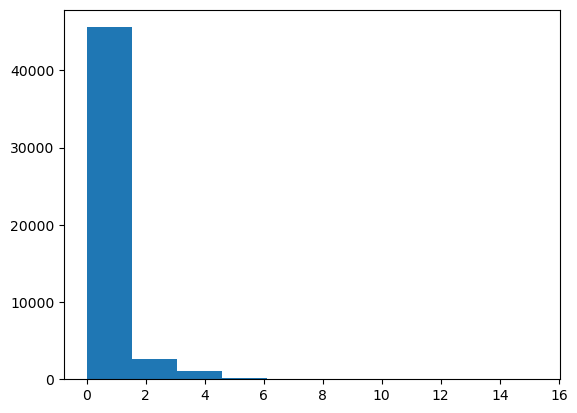

In [10]:
plt.hist(df['z_scores'] )

Filtering for z scores under 3 and removing outliers

In [11]:
df = df[df['z_scores'] < 3].copy()

In [12]:
df = df.drop('z_scores', axis=1)

Let's try some Smoothing, Differencing, Scaling and Normalization

Moving average

In [13]:
moving_avg = df.rolling(window=5).mean()

Differencing

In [14]:
differenced_series = df.diff().dropna()

Scaling

In [15]:
scaler = StandardScaler()
scaled_series = scaler.fit_transform(df.values.reshape(-1, 1))

Let's plot: <br>

A line plot for standard viz <br>
A seasonal plot for seasonal patterns <br>
An autocorrelation plot to check correlation of series with past values <br>

In [16]:
df_monthly = df.resample('ME').mean()

In [17]:
plt.figure(figsize=(15, 18))

<Figure size 1500x1800 with 0 Axes>

<Figure size 1500x1800 with 0 Axes>

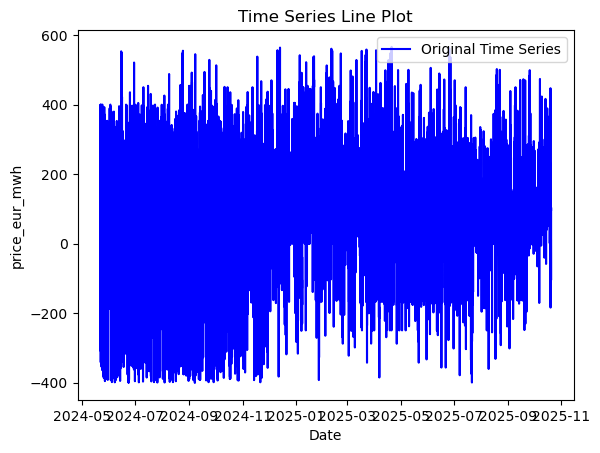

In [18]:
# Line plot
plt.plot(df, label='Original Time Series', color='blue')
plt.title('Time Series Line Plot')
plt.xlabel('Date')
plt.ylabel('price_eur_mwh')
plt.legend()

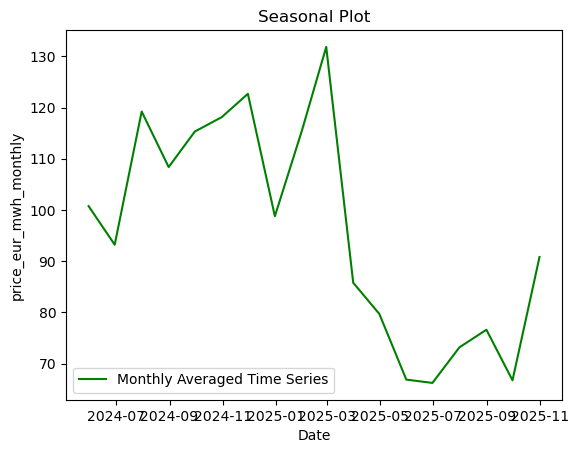

In [19]:
# Seasonal plot
plt.plot(df_monthly, label='Monthly Averaged Time Series', color='green')
plt.title('Seasonal Plot')
plt.xlabel('Date')
plt.ylabel('price_eur_mwh_monthly')
plt.legend()

In [20]:
df.columns

Index(['price_eur_mwh'], dtype='object')

Text(0.5, 1.0, 'Autocorrelation Plot')

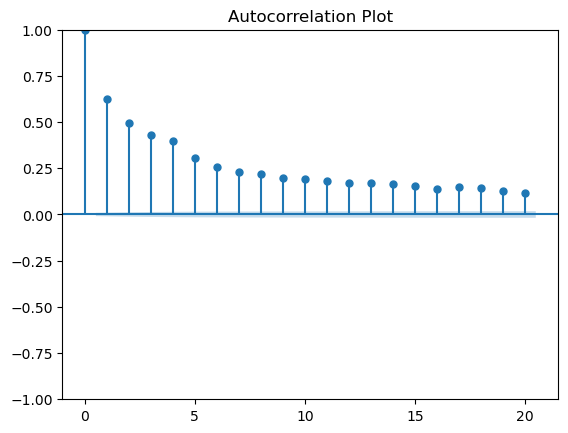

In [21]:
# Autocorrelation plot
plot_acf(df, lags=20, ax=plt.gca())
plt.title('Autocorrelation Plot')

ACF plots correlation of time series with itself at different lags. <br>

A gradual decline suggests a long term dependency in data <br>

Each observation is highly dependant on its recent past values <br>

Non stationarity -> mean and variance likely change overtime (due to trend or seasonality) <br>

Need to difference and account for seasonal/trend component

Text(0.5, 1.0, 'Partial Autocorrelation Plot')

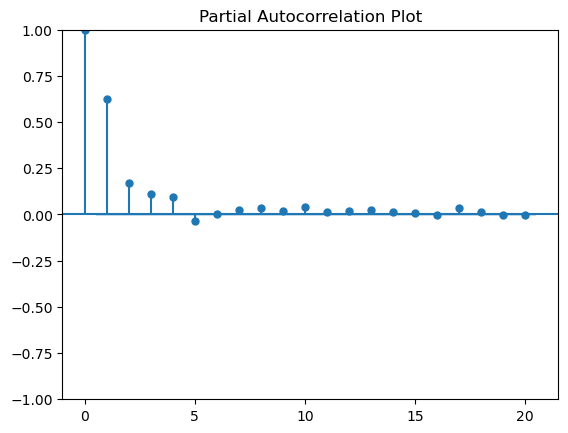

In [22]:
plot_pacf(df, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Plot')

PACF plots correlation between observations at two time points, removing influence of intermediary observations. <br>

Sharp drop after lag 1 suggests one autoregressive term could capture most of the dependency <br>

Correlations insignificant after few lags supports a short memory once first lag is accounted for <br>

ARIMA(1,1,0) after differencing

In [23]:
df.isna().sum()

price_eur_mwh    0
dtype: int64

In [24]:
p = 1
d = 0
q = 0

model = ARIMA(df['price_eur_mwh'], order=(p, d, q))
model_fit = model.fit()

C:\Users\32472\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\32472\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\32472\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [25]:
pred = model_fit.predict(start=1, end=len(df)-1)

In [26]:
y_true = df['price_eur_mwh'].iloc[1:]
rmse = np.sqrt(mean_squared_error(y_true, pred))
mae = mean_absolute_error(y_true, pred)

In [27]:
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")

RMSE: 90.91
MAE:  58.73


In [28]:
# Create a mask for the last 7 days
end_time = df.index.max()
start_time = end_time - pd.Timedelta(days=7)
last_week = df.loc[start_time:end_time]

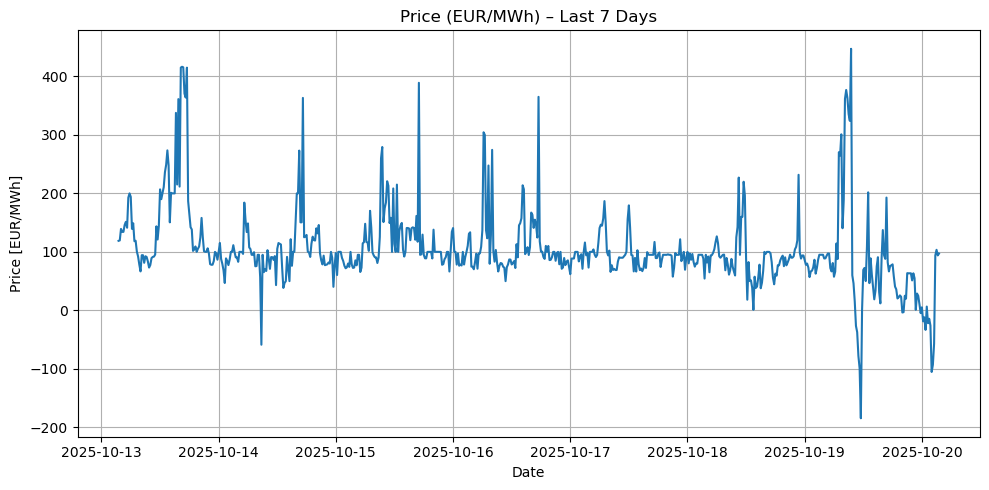

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(last_week.index, last_week['price_eur_mwh'])
plt.title('Price (EUR/MWh) – Last 7 Days')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')
plt.grid(True)
plt.tight_layout()
plt.show()